In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

import yaml
import matplotlib.pyplot as plt
import pandas as pd

from src.data.load import load_data
from src.data.prepare import prepare_data
from src.models.cv_iterator import leave_last_k

In [2]:
# read config
with open('config.yml', 'r') as file:
    config=yaml.load(file, Loader= yaml.SafeLoader)
del file

In [3]:
# load and prepare data
dfs = load_data(config=config['data_loader'])
#dfs = prepare_data(dataframes=dfs)

In [4]:
# train-test split
df_train, df_test = leave_last_k(df=dfs['data'], config=config['optimization'])
del df_test

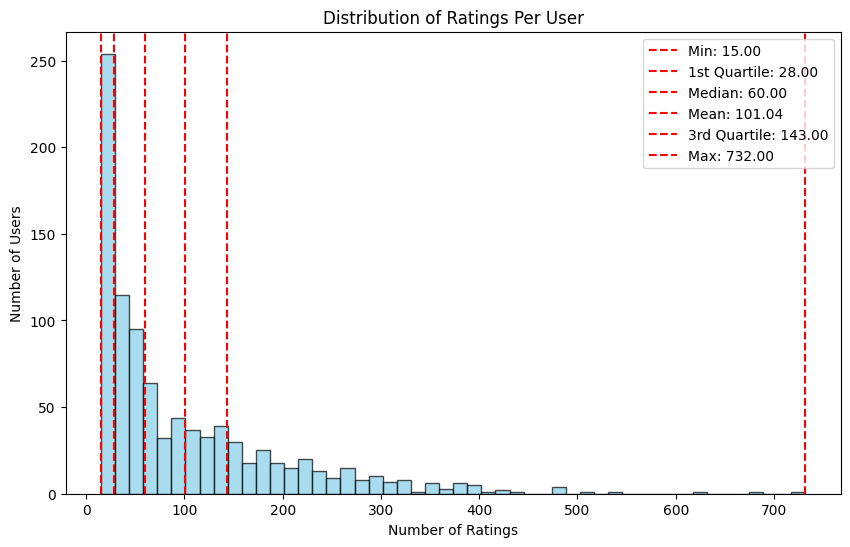

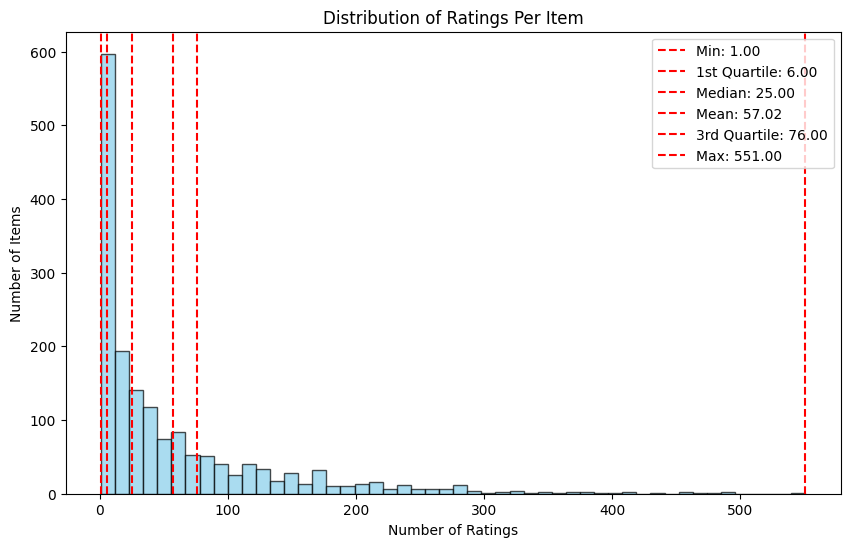

In [5]:
# calculate the number of ratings per user and item
for col in ['user_id', 'item_id']:
    df = df_train.groupby(by=[col]).size().reset_index().rename(columns={0: 'size'})

    # compute summary stats
    stats = {
        'Min': df['size'].min()
        , '1st Quartile': df['size'].quantile(0.25)
        , 'Median': df['size'].median()
        , 'Mean': df['size'].mean()
        , '3rd Quartile': df['size'].quantile(0.75)
        , 'Max': df['size'].max()
    }

    # plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(df['size'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

    # add vertical lines for stats
    for label, value in stats.items():
        plt.axvline(x=value, color='red', linestyle='--', label=f'{label}: {value:.2f}')

    # plot settings
    plt.title(f'Distribution of Ratings Per {col.split(sep="_")[0].capitalize()}')
    plt.xlabel('Number of Ratings')
    plt.ylabel(f'Number of {col.split(sep="_")[0].capitalize()}s')
    plt.legend(loc='upper right')
    plt.grid(False)
    plt.show()

del col, df, stats, label, value

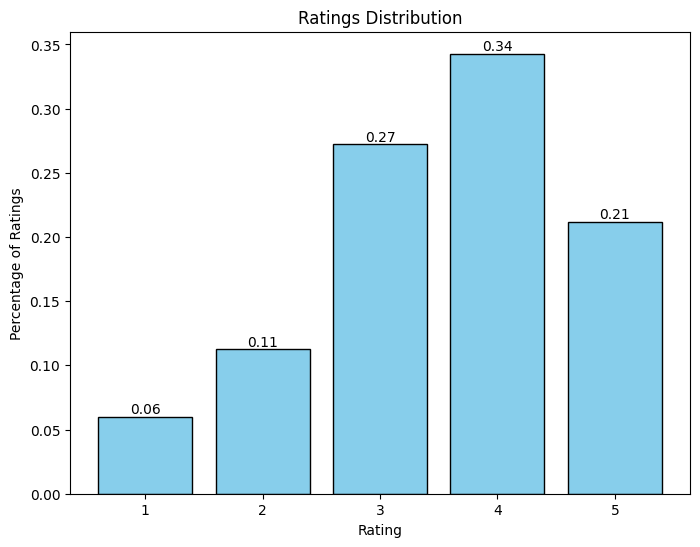

In [6]:
# ratings distribution
ratings_distribution = df_train['rating'].value_counts(normalize=True).reset_index()
ratings_distribution.columns = ['rating', 'percentage']

# plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(ratings_distribution['rating'], ratings_distribution['percentage'], color='skyblue', edgecolor='black')

# plot settings
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Percentage of Ratings')
plt.xticks(ratings_distribution['rating'], rotation=0)

# add percentage to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()
del ratings_distribution, bars, bar, yval

In [7]:
# ratings distribution at the user or item level
for col in ['user_id', 'item_id']:
    df = (
        df_train.groupby(by=[col, 'rating']).size()
        .reset_index().rename(columns={0: 'size'})
    )
    df = (
        df
        .merge(
            df.groupby(by=[col])['size'].sum()
            .reset_index().rename(columns={'size': 't_size'})
            , how='left', on=col
            )
        )
    df['share'] = (df['size']/df['t_size']*100).round(1)
    df = df.pivot(index=col, columns='rating', values='share').reset_index().fillna(0)

    df['1v2'] = df[1] + df[2]
    df['4v5'] = df[4] + df[5]

    display(df.describe().round(1))
del col, df

rating,user_id,1,2,3,4,5,1v2,4v5
count,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0
mean,472.0,5.5,10.5,25.9,35.0,23.1,16.0,58.1
std,272.4,7.9,7.9,11.6,11.8,15.4,12.8,17.7
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,236.5,0.0,5.1,17.6,27.3,11.8,7.1,45.8
50%,472.0,3.0,9.3,25.6,35.3,20.7,13.2,59.8
75%,707.5,7.0,13.8,33.3,42.9,31.7,21.8,70.4
max,943.0,68.6,53.3,69.7,78.4,94.7,87.2,100.0


rating,item_id,1,2,3,4,5,1v2,4v5
count,1671.0,1671.0,1671.0,1671.0,1671.0,1671.0,1671.0,1671.0
mean,836.9,16.0,14.9,28.9,26.5,13.7,30.9,40.2
std,483.7,23.2,16.3,18.9,18.8,15.5,26.8,26.3
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,418.5,1.6,2.8,18.8,12.5,0.0,10.6,20.0
50%,836.0,6.9,11.1,28.4,28.0,9.7,24.0,40.0
75%,1255.5,20.0,21.4,37.5,39.1,21.7,44.4,60.0
max,1682.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


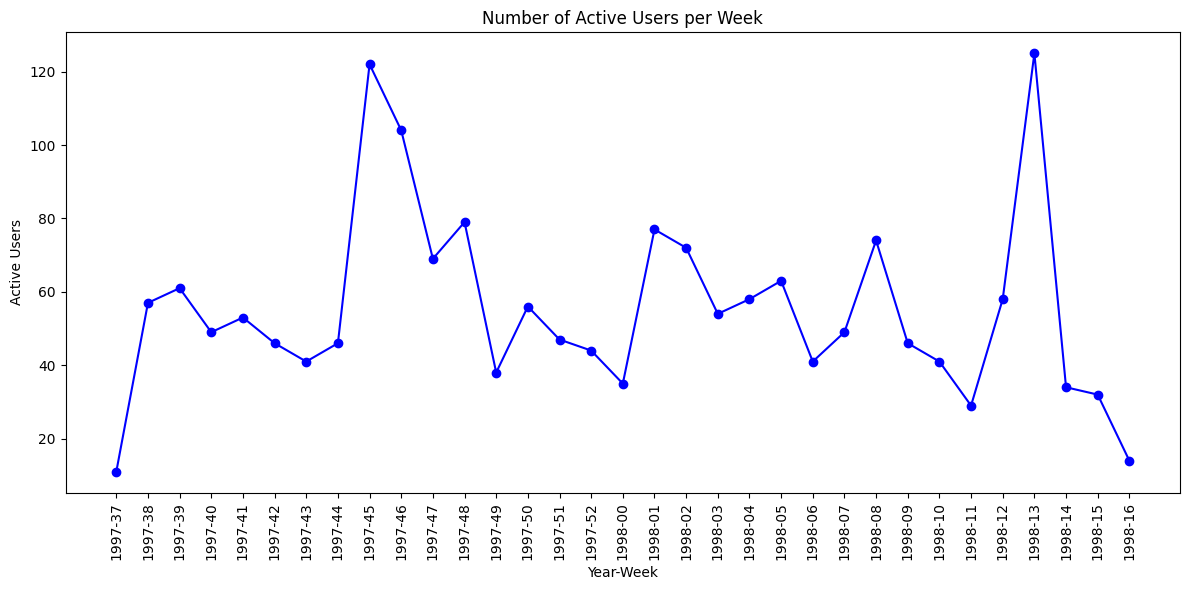

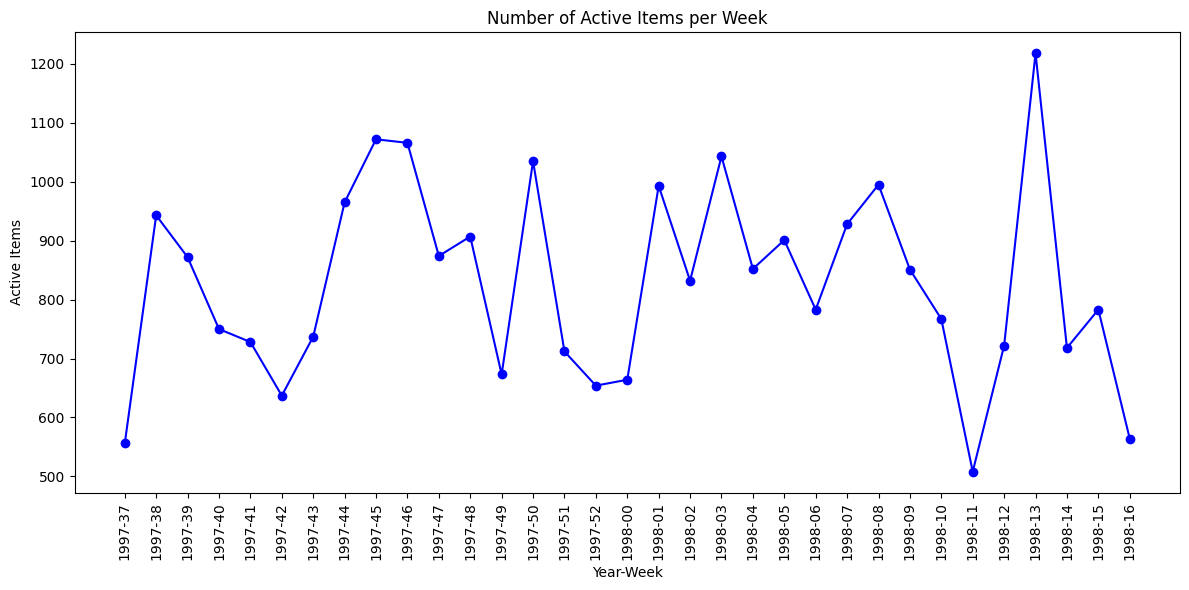

In [8]:
df = df_train.copy()
df['timestamp'] = pd.to_datetime(df_train['timestamp'], unit='s')
df['year_week'] = df['timestamp'].dt.strftime('%Y-%U')

for col in ['user_id', 'item_id']:
    df_i = df.groupby(by=['year_week'])[col].nunique().reset_index()

    # line plot to show active users per week
    plt.figure(figsize=(12, 6))
    plt.plot(df_i['year_week'], df_i[col], marker='o', linestyle='-', color='b')
    plt.title(f'Number of Active {col.split(sep="_")[0].capitalize()}s per Week')
    plt.xlabel('Year-Week')
    plt.ylabel(f'Active {col.split(sep="_")[0].capitalize()}s')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
del col, df_i, df